# Tarea 6 -  COVID-19

### ITESM - Escuela de Ingeniería y Ciencias
#### Maestría en Ciencias Computacionales
#### Aprendizaje Automático

---

## Carlos E. Hdz Rincón - A01181616

# Datos

El presente ejercicio está basado en el siguiente artículo:

https://www.frontiersin.org/articles/10.3389/fpubh.2020.00357/full

El objetivo es determinar si una fallece o no a partir de un historial
clínico.

Utiliza en esta tarea el archivo “train.csv” que encontrarás en el repositorio GitHub dado en el artículo. Los autores separaron previamente en dicho archivo los datos cuya variable de salida “death” no tiene un valor nulo. 

In [ ]:
%matplotlib inline

from IPython.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Connect to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#data_root_location = "/content/drive/My Drive/AprendizajeAutomatico/Assignment6/"
data_root_location = "/workspace/aprauto/assignment6/"

train_filename = "train.csv"

data = pd.read_csv(f"{data_root_location}{train_filename}",
                        header=0)

print(f"Data: {data.shape}")
data.head()

Data: (222, 16)


,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6
0,49,"Wuhan, Hubei",China,male,61.0,12/20/2019,12/27/2019,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,50,"Wuhan, Hubei",China,male,69.0,12/30/2019,1/3/2020,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,51,"Wuhan, Hubei",China,male,89.0,NaN,NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
3,52,"Wuhan, Hubei",China,male,89.0,1/13/2020,1/13/2020,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
4,53,"Wuhan, Hubei",China,male,66.0,1/10/2020,1/16/2020,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN


# a) EDA

Realiza un análisis descriptivo y gráfico de los datos. 

In [ ]:
print(data.columns.values)

['id' 'location' 'country' 'gender' 'age' 'sym_on' 'hosp_vis' 'vis_wuhan'
 'from_wuhan' 'death' 'symptom1' 'symptom2' 'symptom3' 'symptom4'
 'symptom5' 'symptom6']


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          222 non-null    int64  
 1   location    222 non-null    object 
 2   country     222 non-null    object 
 3   gender      211 non-null    object 
 4   age         203 non-null    float64
 5   sym_on      119 non-null    object 
 6   hosp_vis    119 non-null    object 
 7   vis_wuhan   222 non-null    int64  
 8   from_wuhan  222 non-null    int64  
 9   death       222 non-null    int64  
 10  symptom1    51 non-null     object 
 11  symptom2    22 non-null     object 
 12  symptom3    13 non-null     object 
 13  symptom4    0 non-null      float64
 14  symptom5    0 non-null      float64
 15  symptom6    0 non-null      float64
dtypes: float64(4), int64(4), object(8)
memory usage: 27.9+ KB


## Eliminamos columnas sin información de síntomas

No hay manera de extrapolar o rellenar esta información que sólo nos agregaría ruido al entrenamiento.

In [ ]:
data.drop(["symptom4", "symptom5", "symptom6"], axis=1, inplace=True)

## Arreglo de tipo de dato y codificación de categorías

Ya que los tipos de datos no-numéricos fueron importados como strings, se deberá cambiar su tipo a categorías que puedan ser usadas por los modelos.

Las columnas que modelan fechas deben ser cambiadas al tipo apropiado.

Podemos inspeccionar los valores únicos para cada columna categórica para crear un mapa de valores para recodificar las columnas.

In [ ]:
for cat_col in ["location", "country", "gender", "symptom1", "symptom2", "symptom3"]:
    print(f"{cat_col}: {data[cat_col].unique()}\n")

location: ['Wuhan, Hubei' 'Hubei' 'Shandong' 'Paris' 'Kanagawa' 'Japan' 'Tokyo'
 'Hokkaido' 'Ishikawa' 'Saitama Prefecture' 'Chiba Prefecture'
 'Sagamihara' 'Nagoya City' 'Johor' 'Langkawi' 'Malaysia' 'Kathmandu'
 'Singapore' 'South Korea' 'Seoul' 'Taiwan' 'Thailand' 'Washington'
 'Illinois' 'Ho Chi Minh City' 'Vinh Phuc' 'NSW' 'Toronto' 'Sri Lanka'
 'UAE' 'Hong Kong' 'Kowloon' 'Tyumen' 'Zabaikalsky' 'London' 'Manila'
 'Canary Islands' 'Mallorca' 'Egypt' 'Qom']

country: ['China' 'France' 'Japan' 'Malaysia' 'Nepal' 'Singapore' 'South Korea'
 'Taiwan' 'Thailand' 'USA' 'Vietnam' 'Australia' 'Canada' 'Sri Lanka'
 'UAE' 'Hong Kong' 'Russia' 'UK' 'Phillipines' 'Spain' 'Egypt' 'Iran']

gender: ['male' 'female' nan]

symptom1: [nan 'fever' 'fatigue' 'cold' 'difficulty breathing' 'cough' 'sore throat'
 'high fever' 'headache' 'chills' 'myalgia']

symptom2: [nan ' cough' ' fever' ' pneumonia' ' loss of appetite' ' sore throat'
 ' chills' ' shortness of breath' ' headache' ' runny nose']

sympto

In [ ]:
def fix_data_types(df: pd.DataFrame) -> pd.DataFrame:

    # Fix categorical data
    cat_cols = ["location", "country", "gender", "symptom1", "symptom2", "symptom3"]

    df = df.copy()

    for col in cat_cols:
        # Keep the NaN to be treated later as category 0
        # By default, category types will start at 0, so let's shift by 1 to
        #  reserver 0 = NaN
        new_col = df[col].astype('category').cat.codes
        new_col = (new_col + 1).astype(int)
        new_col[new_col == 0] = np.nan
        
        df[col] = new_col

    # Fix data type for date columns
    df.sym_on = pd.to_datetime(df.sym_on)
    df.hosp_vis = pd.to_datetime(df.hosp_vis)
    
    return df

data = fix_data_types(data)

## EDA

In [ ]:
data.describe(include="all", datetime_is_numeric=True)

,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3
count,222.000000,222.000000,222.000000,211.000000,203.000000,119,119,222.000000,222.000000,222.000000,51.000000,22.000000,13.000000
mean,480.968468,25.576577,10.581081,1.620853,49.747537,2020-01-23 11:17:38.823529472,2020-01-26 16:08:04.033613568,0.157658,0.283784,0.283784,5.705882,3.590909,6.153846
min,49.000000,1.000000,1.000000,1.000000,0.250000,2019-12-20 00:00:00,2019-12-27 00:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,321.250000,18.250000,6.000000,1.000000,35.500000,2020-01-13 00:00:00,2020-01-18 12:00:00,0.000000,0.000000,0.000000,6.000000,2.000000,4.000000
50%,479.500000,28.000000,13.000000,2.000000,51.000000,2020-01-24 00:00:00,2020-01-27 00:00:00,0.000000,0.000000,0.000000,6.000000,2.000000,6.000000
75%,604.000000,30.750000,14.000000,2.000000,65.000000,2020-02-01 00:00:00,2020-02-03 00:00:00,0.000000,1.000000,1.000000,6.000000,4.750000,9.000000
max,1037.000000,40.000000,22.000000,2.000000,89.000000,2020-02-20 00:00:00,2020-02-21 00:00:00,1.000000,1.000000,1.000000,10.000000,9.000000,11.000000
std,262.073776,10.135328,5.468147,0.486329,20.462520,NaN,NaN,0.365243,0.451852,0.451852,1.640660,2.538449,3.287505


In [ ]:
data.median(skipna=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


id            479.5
location       28.0
country        13.0
gender          2.0
age            51.0
vis_wuhan       0.0
from_wuhan      0.0
death           0.0
symptom1        6.0
symptom2        2.0
symptom3        6.0
dtype: float64

In [ ]:
data.mode(axis=0)

,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3
0,49,28.0,13.0,2.0,35.0,2020-01-24,2020-01-19,0.0,0.0,0.0,6.0,2.0,4.0
1,50,NaN,NaN,NaN,65.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,10.0
2,51,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,52,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,53,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,1033,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
218,1034,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
219,1035,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
220,1036,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


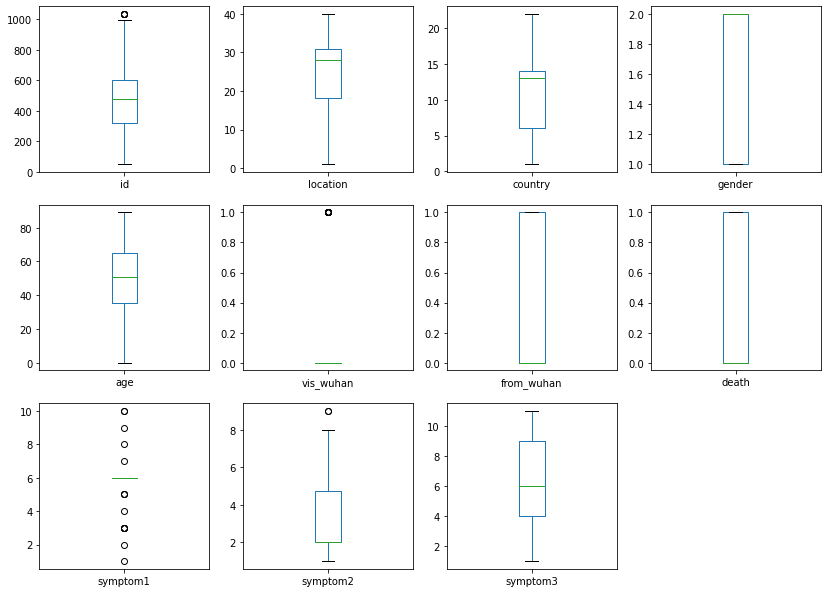

In [ ]:
data.plot.box(subplots=True, layout=(4,4), figsize=(14,14));

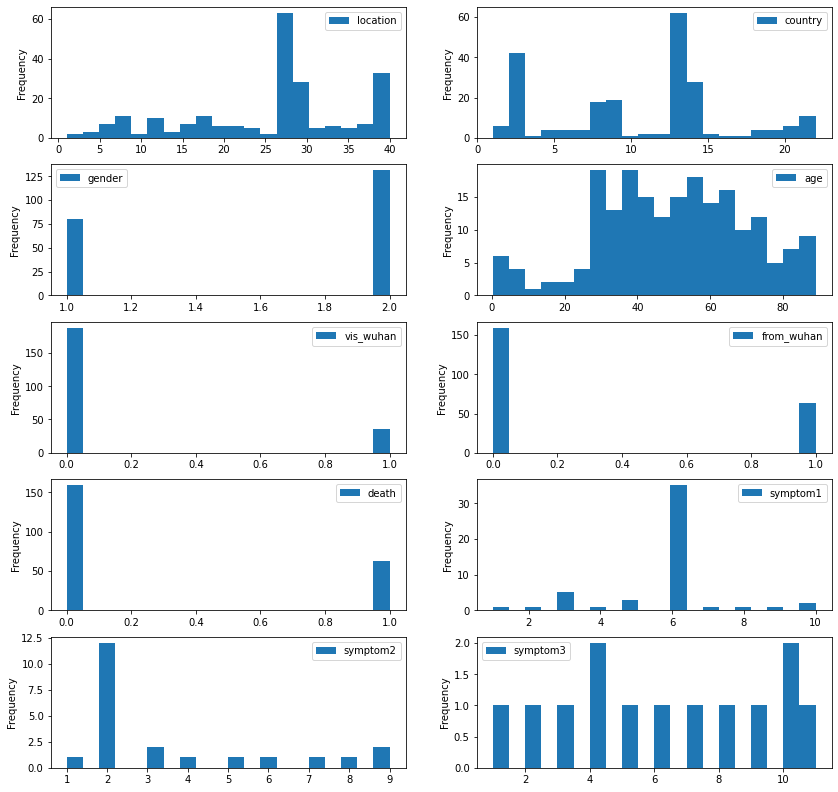

In [ ]:
def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int):

    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=20,
                          legend=True)

plot_histogram(data.drop(["id"], axis=1)._get_numeric_data(), 5, 2)

In [ ]:
data.drop(["id"], axis=1).corr(method="pearson")

,location,country,gender,age,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3
location,1.000000,0.006174,-0.006701,0.159015,0.074342,0.339565,0.215072,0.177740,0.170166,0.415283
country,0.006174,1.000000,-0.065168,-0.355375,0.119312,-0.393023,-0.559675,0.085588,0.342469,0.421948
gender,-0.006701,-0.065168,1.000000,0.025001,0.030847,0.018917,0.174831,-0.138922,0.348228,0.146732
age,0.159015,-0.355375,0.025001,1.000000,-0.207020,0.312940,0.583705,-0.250755,0.021568,0.494811
vis_wuhan,0.074342,0.119312,0.030847,-0.207020,1.000000,-0.272323,-0.244906,0.302223,0.172358,NaN
from_wuhan,0.339565,-0.393023,0.018917,0.312940,-0.272323,1.000000,0.357293,0.153637,-0.433973,-0.188685
death,0.215072,-0.559675,0.174831,0.583705,-0.244906,0.357293,1.000000,-0.327793,0.176926,0.384230
symptom1,0.177740,0.085588,-0.138922,-0.250755,0.302223,0.153637,-0.327793,1.000000,-0.371865,0.063606
symptom2,0.170166,0.342469,0.348228,0.021568,0.172358,-0.433973,0.176926,-0.371865,1.000000,-0.152740
symptom3,0.415283,0.421948,0.146732,0.494811,NaN,-0.188685,0.384230,0.063606,-0.152740,1.000000


In [ ]:
class_column = "death"

num_class_0 = len(data[data[class_column] == 0])
num_class_1 = len(data[data[class_column] == 1])
print(f"Elementos para clase 0: {num_class_0}")
print(f"Elementos para clase 1: {num_class_1}")

Elementos para clase 0: 159
Elementos para clase 1: 63


---

Se puede observar en este análisis que las columnas son en su mayoría categóricas y que la distribución en las columnas de tipo continuo no poseen outliers significativos. La columna de edad no presenta un sesgo significativo.

Podemos enfocarnos en el rellenado de valores nulos y el feature engineering para las columnas de fechas.

# b) Rellenado de valores nulos
Aplica el tratamiento a los datos con valores NA indicado por los autores. Indica el cada factor la cantidad de dichos datos perdidos.

---

## Descripción de estrategia

Excepto por las columnas de síntomas, se tomarán **unas estrategias distintas para el rellenado de valores nulos a las que los autores proponen** que se traducen a mejores resultados.

## hosp_vis y sym_on
Las columnas de fecha para las que no se tengan valores **no se rellenarán en esta fase**, sino hasta el paso de feature engineering donde se combinan en una nueva columna numérica. Ahí, se llenarán los campos con la mediana de la serie de valores del número de días entre que se descubrieron síntomas y se visitó al hospital. Los autores en el paper pusieron estos valores a 0.

## Age
Los autores usan la media como estrategia para rellenar la edad, pero se opta aquí por usar la mediana. La mediana es menos susceptible a cambios bruscos en la distribución de los valores y a la presencia de outliers, además que los valores faltantes son pocos. Para poder mantener una desviación estándar y una escala relativamente sin alteraciones, la mediana es una mejor opción.

## Gender
Los autores traducen los NA en datos categóricos a su propia categoría, de modo que, por ejemplo, los 11 valores faltantes en *gender* poseerán 3 valores únicos *male, female, na*. Dado que los valores faltantes son pocos, podemos utilizar la moda de la columna sin que hayan alteraciones bruscas a la distribución de la columna.

## Symptom1, 2, 3
Se sigue la estrategia de los autores de convertir los valores NA a su propio valor categórico, en este caso se utilizará 0.

## Symptom 4,5,6
Dado que no hay valores para ninguno de los registros, no hay manera de extrapolar la información y si se usaran sólo meterían ruido, por lo que se eliminaron estas columnas.

## Resumen de datos nulos

In [ ]:
data.isnull().sum()

id              0
location        0
country         0
gender         11
age            19
sym_on        103
hosp_vis      103
vis_wuhan       0
from_wuhan      0
death           0
symptom1      171
symptom2      200
symptom3      209
dtype: int64

In [ ]:
def fix_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Gender - use mode and keep the genders 0-1
    df["gender"].fillna(df["gender"].mode()[0], inplace=True)
    df["gender"] = (df["gender"] - 1).astype(int)

    # Age - use median and don't count the na values for the calculation
    df['age'].fillna(df['age'].dropna().median(), inplace=True)

    # sym_on - use mode
    #df["sym_on"].fillna(df["sym_on"].mode()[0], inplace=True)

    # hosp_vis - use mode
    #df["hosp_vis"].fillna(df["hosp_vis"].mode()[0], inplace=True)

    # symptoms - use NA, since we have converted to numbers the categories,
    #  we'll assign NA=0
    for symptom in ["symptom1","symptom2", "symptom3"]:
        #df[symptom] = df[symptom].cat.add_categories('NA')
        df[symptom].fillna(0, inplace=True)
        df[symptom] = df[symptom].astype(int)

    return df


data_fixed = fix_missing_data(data)


print(data_fixed.isnull().sum())
data_fixed.describe(include="all", datetime_is_numeric=True)

id              0
location        0
country         0
gender          0
age             0
sym_on        103
hosp_vis      103
vis_wuhan       0
from_wuhan      0
death           0
symptom1        0
symptom2        0
symptom3        0
dtype: int64


,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3
count,222.000000,222.000000,222.000000,222.00000,222.000000,119,119,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,480.968468,25.576577,10.581081,0.63964,49.854730,2020-01-23 11:17:38.823529472,2020-01-26 16:08:04.033613568,0.157658,0.283784,0.283784,1.310811,0.355856,0.360360
min,49.000000,1.000000,1.000000,0.00000,0.250000,2019-12-20 00:00:00,2019-12-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,321.250000,18.250000,6.000000,0.00000,36.000000,2020-01-13 00:00:00,2020-01-18 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,479.500000,28.000000,13.000000,1.00000,51.000000,2020-01-24 00:00:00,2020-01-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,604.000000,30.750000,14.000000,1.00000,65.000000,2020-02-01 00:00:00,2020-02-03 00:00:00,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1037.000000,40.000000,22.000000,1.00000,89.000000,2020-02-20 00:00:00,2020-02-21 00:00:00,1.000000,1.000000,1.000000,10.000000,9.000000,11.000000
std,262.073776,10.135328,5.468147,0.48119,19.566296,NaN,NaN,0.365243,0.451852,0.451852,2.529065,1.329933,1.638302


# c) Feature engineering
Realiza la transformación de los factores “sym_on” y “hosp_vis” para conjuntarlas en una única variable que contabiliza el total de días desde que aparecieron los síntomas hasta que fueron al hospital.

---

Aquí, se llenarán los campos que tenían fechas nulas con la mediana de la serie de valores del número de días entre que se descubrieron síntomas y se visitó al hospital. Además, se usará el valor absoluto de días y se transformarán los valores a enteros.

In [ ]:
hosp_vis_sym_on = (data_fixed.hosp_vis - data_fixed.sym_on).astype('timedelta64[D]')
hosp_vis_sym_on.fillna(hosp_vis_sym_on.median(), inplace=True)
hosp_vis_sym_on = np.abs(hosp_vis_sym_on).astype("int")

data_fixed["hosp_vis_sym_on"] = hosp_vis_sym_on

data_fixed[["sym_on", "hosp_vis", "hosp_vis_sym_on"]].head(15)

,sym_on,hosp_vis,hosp_vis_sym_on
0,2019-12-20,2019-12-27,7
1,2019-12-30,2020-01-03,4
2,NaT,NaT,2
3,2020-01-13,2020-01-13,0
4,2020-01-10,2020-01-16,6
5,2020-01-12,2020-01-11,1
6,NaT,NaT,2
7,2020-01-09,2020-01-14,5
8,2019-12-22,2019-12-31,9
9,2020-01-15,2020-01-18,3


## Eliminamos las columnas de fechas para sólo dejar la nueva de diferencia de días

Con esto podemos comprobar que ya no quedan datos nulos en nuestro dataset.

In [ ]:
data_final = data_fixed.drop(["sym_on", "hosp_vis"], axis=1)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               222 non-null    int64  
 1   location         222 non-null    int64  
 2   country          222 non-null    int64  
 3   gender           222 non-null    int64  
 4   age              222 non-null    float64
 5   vis_wuhan        222 non-null    int64  
 6   from_wuhan       222 non-null    int64  
 7   death            222 non-null    int64  
 8   symptom1         222 non-null    int64  
 9   symptom2         222 non-null    int64  
 10  symptom3         222 non-null    int64  
 11  hosp_vis_sym_on  222 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 20.9 KB


# d) Partición

Realiza una partición aleatoria de 80% entrenamiento y 20% prueba. Es decir, usando los mismos porcentajes que los autores del artículo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop("death", axis=1),
                                                    data_final[["death"]],
                                                    train_size=0.8,
                                                    random_state=42)
# Ravel the labels to get it in better shape for the training
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (177, 11)
X_test: (45, 11)
y_train: (177,)
y_test: (45,)


# e)

Investiga en qué consisten las siguientes clases de sklearn:

## 1. RandomizedSearchCV
https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Es un método de búsqueda de hiperparámetros que entrena modelos con diferentes selecciones de parámetros y selecciona los mejores mediante un CrossValidation. A diferencia de un GridSearchCV, no todos los parámetros son usados, en cambio se usa un número fijo de combinaciones de parámetros a usar en cada iteración especificado con una distribución probabilística. Soporta muestreo con y sin reemplazo.

Es una buena alternativa cuando un GridSearchCV es computacionalmente muy costoso, particularmente si la población de parámetros a intentar es muy alta e imbalanceada y el entrenamiento de cada modelo es muy tardado.


## 2. GridSearchCV
https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Realiza una búsqueda exhaustiva de hiperparámetros para un estimador o modelo. Los hiperparámetros del estimador se evalúan con CrossValidation sobre una matriz de parámetros y se seleccionan los mejores.

Es muy bueno cuando se maneja un número pequeño de hiperparámetros. Ya que entrenará un modelo por cada combinación única de parámetros. Esto puede hacer que la búsqueda sea computacionalmente muy costosa y tardada, especialmente si el entrenamiento del modelo es muy tardado. En esos casos valdrá la pena mejor usar una búsqueda aleatoria con RandomizedSearchCV.

# Herramientas para evaluación de modelo

In [ ]:
def print_marquee(msg: str):
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

def print_metrics(y_true, y_pred):
    print(metrics.confusion_matrix(y_true, y_pred))
    print("Puntos no categorizados correctamente: %d/%d" 
      % ((y_true != y_pred).sum(), y_true.shape[0]))
    
    print("\n")
    print(metrics.classification_report(y_true, y_pred))

def search_and_evaluate_model(param_searcher, X, y, X_tst, y_tst):

    print_marquee("Buscando hiperparámetros óptimos...")

    param_searcher.fit(X.drop(["id"], axis=1),
                       y)
    
    print("Los mejores parámetros son %s con un score de %0.2f"
        % (param_searcher.best_params_, param_searcher.best_score_))
    

    print_marquee("Reporte de búsqueda de hiperparámetros")
    result_report = pd.DataFrame.from_dict(param_searcher.cv_results_)
    display(result_report)

    print_marquee("Matriz de confusión y reporte de predicciones en dataset de prueba:")
    y_pred = param_searcher.predict(X_tst.drop(["id"], axis=1))
    print_metrics(y_tst, y_pred)



# f) Regresión Logística

En este inciso deberás aplicar modelo de Regresión Logística de sklearn

https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Y la clase RandomizedSearchCV con el conjunto de datos de entrenamiento del 80% generado previamente. Para ello verás definir una malla de búsqueda que al menos incluya los siguientes hiperparámetors y rango de valores siguientes:

1. C: 10 valores.
2. penalty: L1, L2 y None.
3. Solver: lbfgs, saga. (NOTA: Investiga qué significan estos valores).
4. Aplica el modelo de Regresión Logística mediante una búsqueda aleatoria de los mejores valores de los hiperparámetros anteriores con RandomizedSearchCV con n_iter=30, cv=5, scoring=accuracy. (NOTA: Investiga qué significan estos valores).
5. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score.
6. Compara los resultados con los reportados por los autores del artículo con
dicho modelo.

---

### Solver

Determina el algoritmo a usar en el problema de optimización.

Los siguientes algoritmos manejan pérdida multinomial para problemas multiclases.

1. lbfgs. Algoritmo por defecto. 
1. saga. Soporta regularización L1 y L2 y no-regulariación. Convergencia sólo está garantizado en features que estén en la misma escala y es rápido para grandes datasets.

### Parámetros de RandomizedSearchCV

1. n_iter. Número de configuraciones de parámetros que serán seleccionados, maneja un trade-off entre tiempo de ejecución y calidad de la solución.
1. cv. Determina la estrategia para la division para cross-validation. Si no se especifica se usará 5-fold CV. Si se especifica un número será el número de particiones en un KFold. Recibe un objeto CV Splitter o un iterable que proporcione tuplas de sets de entrenamiento y validación como arreglos de índices. Si el estimador es un clasificador se usa un stratified KFold, si no, se usa un simple K-Fold.
1. scoring. Un string or una función que evalúa las predicciones en el set de pruebas. Para evaluar múltiples métricas se puede dar una lista de strings únicos o un dict de nombres y funciones. Si no se especifica, se usa el método *score* del modelo.

In [ ]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100],
    "penalty": ["none", "l1", "l2"],
    "solver": ["lbfgs", "saga"]
    }

logistic_regression_search = RandomizedSearchCV(LogisticRegression(random_state=42),
                                                param_distributions=hyperparams,
                                                verbose=3,
                                                n_jobs=-1,
                                                cv=5,
                                                scoring="accuracy",
                                                random_state=2,
                                                n_iter=30)


search_and_evaluate_model(logistic_regression_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.0s


Los mejores parámetros son {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1} con un score de 0.89


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040889,0.004299,0.001833,0.000115,lbfgs,none,15,"{'solver': 'lbfgs', 'penalty': 'none', 'C': 15}",0.861111,0.944444,0.885714,0.771429,0.885714,0.869683,0.056268,5
1,0.043011,0.008906,0.001835,0.000268,lbfgs,none,0.001,"{'solver': 'lbfgs', 'penalty': 'none', 'C': 0....",0.861111,0.944444,0.885714,0.771429,0.885714,0.869683,0.056268,5
2,0.009206,0.001663,0.001674,0.000231,saga,l2,20,"{'solver': 'saga', 'penalty': 'l2', 'C': 20}",0.833333,0.916667,0.800000,0.857143,0.885714,0.858571,0.040451,13
3,0.011029,0.004958,0.002330,0.000800,saga,none,100,"{'solver': 'saga', 'penalty': 'none', 'C': 100}",0.833333,0.916667,0.800000,0.857143,0.885714,0.858571,0.040451,13
4,0.008596,0.000365,0.001913,0.000189,saga,l2,1,"{'solver': 'saga', 'penalty': 'l2', 'C': 1}",0.833333,0.916667,0.800000,0.857143,0.885714,0.858571,0.040451,13
5,0.039559,0.005682,0.001793,0.000129,lbfgs,l2,20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 20}",0.861111,0.944444,0.885714,0.771429,0.885714,0.869683,0.056268,5
6,0.009313,0.000535,0.003162,0.002344,saga,l2,10,"{'solver': 'saga', 'penalty': 'l2', 'C': 10}",0.833333,0.916667,0.800000,0.857143,0.885714,0.858571,0.040451,13
7,0.039252,0.006557,0.002761,0.001973,lbfgs,l2,5,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 5}",0.861111,0.944444,0.885714,0.800000,0.885714,0.875397,0.046625,3
8,0.011966,0.005556,0.001809,0.000392,saga,none,50,"{'solver': 'saga', 'penalty': 'none', 'C': 50}",0.833333,0.916667,0.800000,0.857143,0.885714,0.858571,0.040451,13
9,0.000812,0.000074,0.000000,0.000000,lbfgs,l1,10,"{'solver': 'lbfgs', 'penalty': 'l1', 'C': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[33  2]
 [ 2  8]]
Puntos no categorizados correctamente: 4/45


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.80      0.80      0.80        10

    accuracy                           0.91        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.91      0.91      0.91        45



---

## Conclusiones

### Parámetros óptimos
Con 5-fold para 30 candidatos, se entrenaron 150 modelos en 3.0s con un score de 0.89 de accuracy.

1. solver: lbfgs
1. penalty: l2
1. C: 0.1

|Parámetro|Paper |Modelo propio|
|:---     |  ---:|  ---:|
|Solver   | lbfgs| lbfgs|
|Penalty  |    l2|    l2|
|C        |   1.0|   0.1|

## Comparación de rendimiento en dataset de entrenamiento de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |Paper|Modelo propio|
|:---     | ---:| ---:|
|Recall   | 0.72| 0.87|
|Precision| 0.66| 0.87|
|F1 Score | 0.69| 0.81|
|Accuracy | 0.84| 0.91|


Se obtuvieron en general mejores resultados que en el paper y el modelo está generalizando bien al dataset de prueba. Esto se debe dos razones:
1. La ingeniería de datos que se usó en lugar de las propuestas por el paper introduce menos ruido y varianza.
1. El paper usa los hiperparámetros por default, mientras que aquí se hizo una mejor búsqueda.

# g) Decision Tree

En este inciso aplicarás ahora un árbol de decisión mediante la clase DecisionTreeClasifier de sklearn

https://scikitlearn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Y los mismos datos de entrenamiento y prueba generados previamente. Para ello verás definir una malla de búsqueda que al menos incluya los siguientes hiperparámetors y rango de valores siguientes:

1. ccp_alpha: 10 valores.
2. Criterio: gini, entropy.
3. Max_depth: 6
4. Min_samples_split: 6
5. Min_samples_leaf: 6
6. Aplica el modelo de Árbol de Decisión mediante una búsqueda aleatoria de los mejores valores de los hiperparámetros anteriores con RandomizedSearchCV con n_iter=100, cv=5, scoring=accuracy.
7. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score.
8. Compara los resultados con los reportados por los autores del artículo con dicho modelo.

In [ ]:
hyperparams_dec_tree = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1, 5, 10, 20, 25],
    "criterion": ["gini", "entropy"],
    #"max_depth": [6],
    #"min_samples_leaf": [6],
    #"min_samples_split": [6]
    }

decision_tree_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42,
                                                                 max_depth=6,
                                                                 min_samples_leaf=6,
                                                                 min_samples_split=6),
                                                param_distributions=hyperparams_dec_tree,
                                                verbose=3,
                                                n_jobs=-1,
                                                cv=5,
                                                scoring="accuracy",
                                                random_state=42,
                                                n_iter=100)

search_and_evaluate_model(decision_tree_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Los mejores parámetros son {'criterion': 'entropy', 'ccp_alpha': 0.001} con un score de 0.85


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004730,0.002363,0.001920,0.000923,gini,0.001,"{'criterion': 'gini', 'ccp_alpha': 0.001}",0.777778,0.944444,0.857143,0.800000,0.828571,0.841587,0.057952,4
1,0.006844,0.003526,0.001461,0.000098,entropy,0.001,"{'criterion': 'entropy', 'ccp_alpha': 0.001}",0.777778,0.944444,0.828571,0.857143,0.828571,0.847302,0.054898,1
2,0.003533,0.000220,0.001725,0.000352,gini,0.01,"{'criterion': 'gini', 'ccp_alpha': 0.01}",0.777778,0.944444,0.857143,0.771429,0.828571,0.835873,0.062963,6
3,0.004577,0.002270,0.001714,0.000138,entropy,0.01,"{'criterion': 'entropy', 'ccp_alpha': 0.01}",0.777778,0.944444,0.828571,0.857143,0.828571,0.847302,0.054898,1
4,0.003724,0.000193,0.001533,0.000058,gini,0.1,"{'criterion': 'gini', 'ccp_alpha': 0.1}",0.750000,0.777778,0.742857,0.800000,0.771429,0.768413,0.020429,8
5,0.003449,0.000268,0.002607,0.002339,entropy,0.1,"{'criterion': 'entropy', 'ccp_alpha': 0.1}",0.888889,0.777778,0.742857,0.828571,0.828571,0.813333,0.049808,7
6,0.002993,0.000204,0.001424,0.000053,gini,0,"{'criterion': 'gini', 'ccp_alpha': 0}",0.777778,0.944444,0.857143,0.800000,0.828571,0.841587,0.057952,4
7,0.003104,0.000185,0.001409,0.000049,entropy,0,"{'criterion': 'entropy', 'ccp_alpha': 0}",0.777778,0.944444,0.828571,0.857143,0.828571,0.847302,0.054898,1
8,0.004619,0.002695,0.002905,0.002456,gini,0.5,"{'criterion': 'gini', 'ccp_alpha': 0.5}",0.694444,0.694444,0.714286,0.714286,0.685714,0.700635,0.011593,9
9,0.005424,0.004381,0.001519,0.000239,entropy,0.5,"{'criterion': 'entropy', 'ccp_alpha': 0.5}",0.694444,0.694444,0.714286,0.714286,0.685714,0.700635,0.011593,9




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[32  3]
 [ 1  9]]
Puntos no categorizados correctamente: 4/45


              precision    recall  f1-score   support

           0       0.97      0.91      0.94        35
           1       0.75      0.90      0.82        10

    accuracy                           0.91        45
   macro avg       0.86      0.91      0.88        45
weighted avg       0.92      0.91      0.91        45



---

## Conclusiones

### Parámetros óptimos
Con 5-fold para 20 candidatos, se entrenaron 100 modelos en 0.4s con un score de 0.85 de accuracy.

|Parámetro|Paper |Modelo propio|
|:---     |  ---:|   ---:|
|criterion|  gini|entropy|
|ccp_alpha|   0.0|  0.001|

## Comparación de rendimiento en dataset de entrenamiento de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |Paper|Modelo propio|
|:---     | ---:| ---:|
|Recall   | 0.55| 0.91|
|Precision| 0.86| 0.86|
|F1 Score | 0.66| 0.88|
|Accuracy | 0.87| 0.91|


La precisión fue la misma en los dos modelos pero se obtuvieron en general mejores resultados que en el paper y el modelo está generalizando bien al dataset de prueba. Esto se debe dos razones:

1. La ingeniería de datos que se usó en lugar de las propuestas por el paper introduce menos ruido y varianza.
1. El paper usa los hiperparámetros por default, mientras que aquí se hizo una mejor búsqueda.





# h) SVC

En este inciso usarás el método de Máquina de Vectores de Soporte (https://scikitlearn.org/stable/modules/generated/sklearn.svm.SVC.html ) y los mismos datos de entrenamiento y prueba generados previamente. Para ello verás definir una malla de búsqueda que al menos incluya los siguientes hiperparámetors y rango de valores siguientes:

1. C: 10 valores.
2. Kernel: linear, poly, rbf, sigmoid.
3. Degree: 6 valores.
4. Gamma: scale, auto.
5. Aplica el modelo SVM mediante una búsqueda aleatoria de los mejores valores de los hiperparámetros anteriores con RandomizedSearchCV con n_iter=100, cv=5, scoring=accuracy.
6. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score.
7. Compara los resultados con los reportados por los autores del artículo con
dicho modelo. 

In [ ]:
hyperparams_svc = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100],
    "kernel": ["linear",
               "poly",
               "rbf",
               "sigmoid"],
    "degree": [1,2,3,4,5,6],
    "gamma": ["scale", "auto"],
    }

svc_search = RandomizedSearchCV(SVC(random_state=42),
                                param_distributions=hyperparams_svc,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(svc_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed: 17.3min


Los mejores parámetros son {'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'C': 10} con un score de 0.89


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 27.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_degree,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005117,0.001243,0.002286,0.001318,poly,scale,2,10,"{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.888889,0.916667,0.885714,0.914286,0.857143,0.892540,0.021762,1
1,0.177138,0.052345,0.001782,0.000183,linear,scale,1,20,"{'kernel': 'linear', 'gamma': 'scale', 'degree...",0.888889,0.944444,0.885714,0.771429,0.885714,0.875238,0.056519,22
2,0.003741,0.000063,0.001375,0.000032,poly,scale,5,0.001,"{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.805556,0.777778,0.742857,0.771429,0.714286,0.762381,0.031232,63
3,0.003867,0.000366,0.001420,0.000129,rbf,scale,2,10,"{'kernel': 'rbf', 'gamma': 'scale', 'degree': ...",0.888889,0.916667,0.857143,0.914286,0.828571,0.881111,0.033942,10
4,0.184221,0.087168,0.001799,0.000089,poly,auto,2,0.1,"{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.888889,0.916667,0.800000,0.771429,0.800000,0.835397,0.056682,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.003463,0.000288,0.001383,0.000092,rbf,scale,5,20,"{'kernel': 'rbf', 'gamma': 'scale', 'degree': ...",0.916667,0.916667,0.857143,0.914286,0.828571,0.886667,0.036904,5
96,51.997362,33.616222,0.001913,0.000133,poly,auto,2,100,"{'kernel': 'poly', 'gamma': 'auto', 'degree': ...",0.694444,0.944444,0.742857,0.800000,0.828571,0.802063,0.084931,61
97,1.025620,0.653136,0.001603,0.000190,linear,auto,3,100,"{'kernel': 'linear', 'gamma': 'auto', 'degree'...",0.888889,0.944444,0.828571,0.771429,0.885714,0.863810,0.058969,41
98,0.002658,0.000481,0.001229,0.000219,sigmoid,auto,5,10,"{'kernel': 'sigmoid', 'gamma': 'auto', 'degree...",0.694444,0.694444,0.714286,0.714286,0.685714,0.700635,0.011593,74




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[34  1]
 [ 4  6]]
Puntos no categorizados correctamente: 5/45


              precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       0.86      0.60      0.71        10

    accuracy                           0.89        45
   macro avg       0.88      0.79      0.82        45
weighted avg       0.89      0.89      0.88        45



---

## Conclusiones

### Hiperparámetros óptimos
Con 5-fold para 100 candidatos, se entrenaron 500 modelos en 27.4m con un score de 0.89 de accuracy.

|Parámetro|Paper |Modelo propio|
|:---     |  ---:|   ---:|
|C        |   1.0|     10|
|kernel   |   rbg|   poly|
|degree   |     3|      2|
|gamma    | scale|  scale|

## Comparación de rendimiento en dataset de entrenamiento de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |Paper|Modelo propio|
|:---     | ---:| ---:|
|Recall   | 0.64| 0.79|
|Precision| 0.70| 0.88|
|F1 Score | 0.66| 0.82|
|Accuracy | 0.84| 0.89|

Se obtuvieron mejores resultados que en el paper y esto se debe mucho al pre-procesamiento de datos y feature engineering y la búsqueda de hiperparámetros óptimos.

Los resultados fueron ligeramente peor que regresión logística y que Decision Tree y el tiempo de entrenamiento fue mucho mayor, lo que indica que las SVM no son muy prácticas en esta clase de problemas.



# i) Gaussian Naïve Bayes

En este inciso usarás el método Bayes Ingenuo Gaussiano (https://scikitlearn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html ) y los mismos datos de entrenamiento y prueba generados previamente.

1. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score.
2. Compara los resultados con los reportados por los autores del artículo con dicho modelo.
3. ¿Por qué no fue necesario aplicar RandomizedSearchCV en este caso?
    * Porque no hay hiperparámetros que ajustar en este modelo bayesiano.

In [ ]:
gaussianNB_model = GaussianNB()
gaussianNB_model.fit(X_train.drop(["id"], axis=1),
                     y_train)

print_marquee("Matriz de confusión y reporte de predicciones en dataset de prueba:")

y_pred_gauss_bayes = gaussianNB_model.predict(X_test.drop(["id"], axis=1))

print_metrics(y_test, y_pred_gauss_bayes)



***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[31  4]
 [ 3  7]]
Puntos no categorizados correctamente: 7/45


              precision    recall  f1-score   support

           0       0.91      0.89      0.90        35
           1       0.64      0.70      0.67        10

    accuracy                           0.84        45
   macro avg       0.77      0.79      0.78        45
weighted avg       0.85      0.84      0.85        45



---

## Conclusiones

## Comparación de rendimiento en dataset de entrenamiento de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |Paper|Modelo propio|
|:---     | ---:| ---:|
|Recall   | 0.73| 0.79|
|Precision| 0.53| 0.77|
|F1 Score | 0.61| 0.78|
|Accuracy | 0.77| 0.84|

Se obtuvieron mejores resultados que los del paper en todas las métricas, lo que permite comprobar que la ingeniería de features es un factor importante en los modelos propuestos y permite comparar claramente cómo la estrategia adoptada, aunque diferente de los autores, permite conseguir mejores resultados.

Sin embargo, este modelo es el que hasta el momento ha tenido peor rendimiento.

# j) Random Forest

En este inciso aplicarás el método de Random Forest (https://scikitlearn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html ) y los mismos datos de entrenamiento y prueba generados previamente. Para ello verás definir una malla de búsqueda que al menos incluya los siguientes hiperparámetors y rango de valores siguientes:

1. bootstrap: True, False.
2. ccp_alpha: 10 valores.
3. Criterio: gini, entropy.
4. Max_depth: 6
5. Min_samples_split: 6
6. Min_samples_leaf: 6
7. n_estimators: 10 valores.
8. oob_score: True, False.
9. Aplica el modelo Random Forest mediante una búsqueda aleatoria de los mejores valores de los hiperparámetros anteriores con RandomizedSearchCV con n_iter=100, cv=5, scoring=accuracy.
10. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score. 

In [ ]:
hyperparams_rf = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1, 5, 10, 20, 25],
    "criterion": ["gini", "entropy"],
    "n_estimators": [1, 5, 10, 20, 25, 50, 75, 100, 250, 500],
    "oob_score": [True, False],
    "bootstrap": [True, False]
    }

rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42,
                                                      max_depth=6,
                                                      min_samples_leaf=6,
                                                      min_samples_split=6),
                                param_distributions=hyperparams_rf,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(rf_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   37.4s


Los mejores parámetros son {'oob_score': False, 'n_estimators': 75, 'criterion': 'gini', 'ccp_alpha': 0, 'bootstrap': False} con un score de 0.89


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.8s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_oob_score,param_n_estimators,param_criterion,param_ccp_alpha,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003387,0.001164,0.000000,0.000000,True,250,gini,10,False,"{'oob_score': True, 'n_estimators': 250, 'crit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,72
1,0.039967,0.001815,0.005323,0.001465,False,20,entropy,5,False,"{'oob_score': False, 'n_estimators': 20, 'crit...",0.694444,0.694444,0.714286,0.714286,0.685714,0.700635,0.011593,26
2,0.017032,0.001371,0.002688,0.000036,False,5,entropy,0.01,True,"{'oob_score': False, 'n_estimators': 5, 'crite...",0.888889,0.944444,0.800000,0.828571,0.857143,0.863810,0.049978,21
3,0.124288,0.001708,0.011757,0.000268,False,75,gini,0,False,"{'oob_score': False, 'n_estimators': 75, 'crit...",0.916667,0.944444,0.885714,0.857143,0.857143,0.892222,0.034141,1
4,0.064249,0.006362,0.004847,0.000068,True,20,entropy,0.01,True,"{'oob_score': True, 'n_estimators': 20, 'crite...",0.888889,0.972222,0.800000,0.857143,0.828571,0.869365,0.059306,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.002229,0.000124,0.000000,0.000000,True,25,gini,1,False,"{'oob_score': True, 'n_estimators': 25, 'crite...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
96,0.021703,0.002071,0.003400,0.000171,False,10,entropy,10,False,"{'oob_score': False, 'n_estimators': 10, 'crit...",0.694444,0.694444,0.714286,0.714286,0.685714,0.700635,0.011593,26
97,0.003272,0.002169,0.000000,0.000000,True,100,entropy,20,False,"{'oob_score': True, 'n_estimators': 100, 'crit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,77
98,0.234597,0.057701,0.011164,0.003357,True,100,gini,0.01,True,"{'oob_score': True, 'n_estimators': 100, 'crit...",0.916667,0.944444,0.857143,0.857143,0.828571,0.880794,0.042858,8




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[35  0]
 [ 0 10]]
Puntos no categorizados correctamente: 0/45


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        10

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



---

## Conclusiones

El paper no usa RandomForest explícitamente, pero sí lo usa a través de un Booster. Se hacen los comparativos con el RandomForest que el paper usa como modelo base para el booster.

### Parámetros óptimos
Con 5-fold para 100 candidatos, se entrenaron 500 modelos en 47.8s con un score de 0.89 de accuracy.

|Parámetro            |Paper |Modelo propio|
|:---                 |  ---:|   ---:|
|criterion            |  gini|   gini|
|ccp_alpha            |   0.0|    0.0|
|n_estimators         |   100|     75|
|oob_score            | False|  False|
|bootstrap            |  True|  False|
|max_depth$^1$        |     2|      6|
|min_samples_leaf$^1$ |     2|      6|
|min_samples_split$^1$|     2|      6|

$^1$ El parámetro no fue buscado con Random o Grid Search, sino que fue usado constantemente en la búsqueda de los otros.

## Comparación de rendimiento en dataset de entrenamiento de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |Paper|Modelo propio|
|:---     | ---:| ---:|
|Recall   |   NA| 1.00|
|Precision|   NA| 1.00|
|F1 Score |   NA| 1.00|
|Accuracy |   NA| 1.00|

Dado que el paper no hizo un modelo de sólo RandomForests, no es posible un comparativo directo, sin embargo los resultados son excelentes en el dataset de prueba y demuestra que el árbol clasificó correctamente las 45 muestras e hizo una buena generalización.

Esto se debe a varias razones:

1. La ingeniería de datos y features diferentes a los del paper tienen un comportamiento más fácil de usar para un árboles de decisión.
1. Los RF son muy buenos estimadores para grupos bien definidos como los que se crearon durante el *feature engineering*.
1. No son tan susceptibles a problemas de escala o normalización como otros modelos, por lo que la preparación de datos es mínima en comparación con ellos.

Sin embargo, antes de hacer una determinación de eficacia concluyente hay que tener presentes algunas limitantes que los RF tienen inherentemente:
1. Dado que los RF calculan el promedio del output de varios árboles y estos árboles a su vez fueron creados de datasets definidos, los RF **tienen problemas para extrapolar a datos que nunca ha visto**.
 * Esto es particularmente cierto cuando se maneja información de series de tiempo como fechas.
 * En nuestro caso, no estamos usando ya una columna de fechas, ya que creamos una nueva columna de diferencia entre *sym_on* y *hosp_on*, sin embargo, si existieran rangos de valores más grandes de los que los árboles vieron durante el entrenamiento, el accuracy muy probablemente se reducirá.

Los RF son buenos modelos para explorar y definir un buen baseline a superar cuando se exploran problemas nuevos con Machine Learning.

# k) AdaBoostClassifier

Repite el inciso anterior, pero ahora usando Random Forest con AdaBoost, es decir, aplicar Boosting Random Forest (https://scikitlearn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html ).

1. Aplica el modelo Boosting Random Forest buscando los mejores hiperparámetros que consideres adecuados.
2. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score.
3. Compara los resultados con los reportados por los autores del artículo con dicho modelo.

In [ ]:
hyperparams_ada = {
    "algorithm": ["SAMME", "SAMME.R"],
    "learning_rate": [0.001, 0.003, 1, 3],
    "n_estimators": [1, 5, 10, 20, 25, 50, 75, 100, 250, 500],
    }

base_estimator = RandomForestClassifier(random_state=42,
                                        max_depth=6,
                                        min_samples_leaf=6,
                                        min_samples_split=6)

ada_search = RandomizedSearchCV(AdaBoostClassifier(random_state=42,
                                                   base_estimator=base_estimator),
                                param_distributions=hyperparams_ada,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(ada_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 51.4min finished


Los mejores parámetros son {'n_estimators': 500, 'learning_rate': 0.003, 'algorithm': 'SAMME'} con un score de 0.91


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.241124,0.002510,0.018330,0.003048,1,0.001,SAMME,"{'n_estimators': 1, 'learning_rate': 0.001, 'a...",0.916667,0.944444,0.857143,0.857143,0.857143,0.886508,0.037022,40
1,1.192259,0.007223,0.073347,0.002910,5,0.001,SAMME,"{'n_estimators': 5, 'learning_rate': 0.001, 'a...",0.916667,0.944444,0.857143,0.857143,0.857143,0.886508,0.037022,40
2,2.383262,0.023137,0.140898,0.002682,10,0.001,SAMME,"{'n_estimators': 10, 'learning_rate': 0.001, '...",0.916667,0.944444,0.857143,0.857143,0.857143,0.886508,0.037022,40
3,4.727446,0.018118,0.283940,0.003621,20,0.001,SAMME,"{'n_estimators': 20, 'learning_rate': 0.001, '...",0.916667,0.944444,0.857143,0.857143,0.857143,0.886508,0.037022,40
4,5.889743,0.033857,0.353736,0.005713,25,0.001,SAMME,"{'n_estimators': 25, 'learning_rate': 0.001, '...",0.916667,0.944444,0.857143,0.857143,0.857143,0.886508,0.037022,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.820625,0.613789,0.107558,0.035944,50,3,SAMME.R,"{'n_estimators': 50, 'learning_rate': 3, 'algo...",0.916667,0.944444,0.885714,0.828571,0.942857,0.903651,0.043196,13
76,1.787495,0.604584,0.112024,0.038690,75,3,SAMME.R,"{'n_estimators': 75, 'learning_rate': 3, 'algo...",0.916667,0.944444,0.885714,0.828571,0.942857,0.903651,0.043196,13
77,1.811595,0.607471,0.113781,0.040686,100,3,SAMME.R,"{'n_estimators': 100, 'learning_rate': 3, 'alg...",0.916667,0.944444,0.885714,0.828571,0.942857,0.903651,0.043196,13
78,1.805797,0.616368,0.109721,0.036837,250,3,SAMME.R,"{'n_estimators': 250, 'learning_rate': 3, 'alg...",0.916667,0.944444,0.885714,0.828571,0.942857,0.903651,0.043196,13




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[35  0]
 [ 0 10]]
Puntos no categorizados correctamente: 0/45


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        10

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



---

## Conclusiones

### Parámetros óptimos

#### Random Forest
Para el RandomForest que se usa como base no se hizo búsqueda explícita de parámetros, se usaron los siguientes:

|Parámetro            |Paper |Modelo propio|
|:---                 |  ---:|   ---:|
|criterion            |  gini|   gini|
|ccp_alpha            |   0.0|    0.0|
|n_estimators         |   100|    100|
|oob_score            | False|  False|
|bootstrap            |  True|   True|
|max_depth            |     2|      6|
|min_samples_leaf     |     2|      6|
|min_samples_split    |     2|      6|

### AdaBoostClassifier

Con 5-fold para 80 candidatos, se entrenaron 400 modelos en 51.4m con un score de 0.91 de accuracy.

|Parámetro            |Paper  |Modelo propio|
|:---                 |   ---:|   ---:|
|n_estimators         |     50|    500|
|learning_rate        |   0.01|  0.003|
|algorithm            |SAMME.R|  SAMME|


## Comparación de rendimiento en dataset de entrenamiento de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |Paper|Modelo propio|
|:---     | ---:| ---:|
|Recall   | 0.75| 1.00|
|Precision|  1.0| 1.00|
|F1 Score | 0.86| 1.00|
|Accuracy | 0.93| 1.00|

Los resultados son excelentes en el dataset de prueba y demuestra que el árbol clasificó correctamente las 45 muestras e hizo una buena generalización.

Esto se debe a varias razones:

1. La ingeniería de datos y features diferentes a los del paper tienen un comportamiento más fácil de usar para un árboles de decisión.
1. Los RF son muy buenos estimadores para grupos bien definidos como los que se crearon durante el *feature engineering*.
1. No son tan susceptibles a problemas de escala o normalización como otros modelos, por lo que la preparación de datos es mínima en comparación con ellos.

Sin embargo, y como se mencionó anteriormente, antes de hacer una determinación de eficacia concluyente hay que recordar que un Boosted RandomForest posee algunas de las limitantes que los RF tienen también:

1. Dado que los RF calculan el promedio del output de varios árboles y estos árboles a su vez fueron creados de datasets definidos, los RF **tienen problemas para extrapolar a datos que nunca ha visto**.
 * Esto es particularmente cierto cuando se maneja información de series de tiempo como fechas.
 * En nuestro caso, no estamos usando ya una columna de fechas, ya que creamos una nueva columna de diferencia entre *sym_on* y *hosp_on*, sin embargo, si existieran rangos de valores más grandes de los que los árboles vieron durante el entrenamiento, el accuracy muy probablemente se reducirá.

Cabe mencionar que estos resultados se asemejan a los del RandomForest sin boost, lo que puede indicar que en este caso, el boost puede no estar aportando mucho al modelo y que el factor determinante es la diferencia de estrategia durante el *feature engineering*.

# l) El mejor modelo

Con base al mejor modelo encontrado en los icniso anteriores, realiza una segunda búsqueda más fina de los hiperparámetors correspondientes (fine tunning) mediante GridSearchCV.

1. Aplica el modelo correspondiente con GridSearchCV definiendo la malla de búsqueda más fina que consideres adecuada.
2. Reporta los mejores valores encontrados en los datos de prueba del 20% generados previamente, la matriz de confusión y las métricas accuracy, precision, recall y f1-score.
3. Compara los resultados con el mejor modelo reportado por los autores del artículo. 

## Entrenamos un RandomForest como base

Usamos GridSearch para buscar sus mejores parámetros

In [ ]:
hyperparams_best_base = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1],
    "criterion": ["gini", "entropy"],
    "n_estimators": [50, 75, 100, 250, 500],
    "oob_score": [True, False],
    "bootstrap": [True, False],
    "max_depth": [None, 3, 6],
    "min_samples_leaf": [1, 4, 6],
    "min_samples_split": [2, 4, 6]
    }

best_base_search = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=hyperparams_best_base,
                                verbose=3,
                                n_jobs=-1,
                                cv=3,
                                scoring="accuracy")

search_and_evaluate_model(best_base_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 3 folds for each of 6480 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 3868 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 4604 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 5404 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 6268 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | e

Los mejores parámetros son {'bootstrap': True, 'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75, 'oob_score': True} con un score de 0.93


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_ccp_alpha,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.149882,0.003878,0.008912,0.000291,True,0.001,gini,None,1,2,50,True,"{'bootstrap': True, 'ccp_alpha': 0.001, 'crite...",0.949153,0.898305,0.932203,0.926554,0.021139,23
1,0.124755,0.006631,0.009200,0.000461,True,0.001,gini,None,1,2,50,False,"{'bootstrap': True, 'ccp_alpha': 0.001, 'crite...",0.949153,0.898305,0.932203,0.926554,0.021139,23
2,0.218819,0.000759,0.012330,0.000478,True,0.001,gini,None,1,2,75,True,"{'bootstrap': True, 'ccp_alpha': 0.001, 'crite...",0.966102,0.898305,0.932203,0.932203,0.027678,1
3,0.174438,0.000870,0.012292,0.000229,True,0.001,gini,None,1,2,75,False,"{'bootstrap': True, 'ccp_alpha': 0.001, 'crite...",0.966102,0.898305,0.932203,0.932203,0.027678,1
4,0.294396,0.005972,0.015759,0.000100,True,0.001,gini,None,1,2,100,True,"{'bootstrap': True, 'ccp_alpha': 0.001, 'crite...",0.949153,0.898305,0.932203,0.926554,0.021139,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,0.173919,0.002257,0.014887,0.000213,False,1,entropy,6,6,6,100,False,"{'bootstrap': False, 'ccp_alpha': 1, 'criterio...",0.711864,0.694915,0.694915,0.700565,0.007990,3241
6476,0.003744,0.001887,0.000000,0.000000,False,1,entropy,6,6,6,250,True,"{'bootstrap': False, 'ccp_alpha': 1, 'criterio...",NaN,NaN,NaN,NaN,NaN,5380
6477,0.440644,0.004135,0.035539,0.001100,False,1,entropy,6,6,6,250,False,"{'bootstrap': False, 'ccp_alpha': 1, 'criterio...",0.711864,0.694915,0.694915,0.700565,0.007990,3241
6478,0.003495,0.001846,0.000000,0.000000,False,1,entropy,6,6,6,500,True,"{'bootstrap': False, 'ccp_alpha': 1, 'criterio...",NaN,NaN,NaN,NaN,NaN,6479




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[34  1]
 [ 0 10]]
Puntos no categorizados correctamente: 1/45


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.91      1.00      0.95        10

    accuracy                           0.98        45
   macro avg       0.95      0.99      0.97        45
weighted avg       0.98      0.98      0.98        45



## Boosteamos el modelo base con Adaboost

Refinamos la búsqueda de hiperparámetros para AdaBoost usando GridSearch

In [ ]:

best_base_estimator = best_base_search.best_estimator_

hyperparams_best_ada = {
    "algorithm": ["SAMME", "SAMME.R"],
    "learning_rate": [0.003, 0.009, 1],
    "n_estimators": [100, 250, 500, 1000],
    }

ada_best_search = GridSearchCV(AdaBoostClassifier(random_state=42,
                                                  base_estimator=best_base_estimator),
                                param_grid=hyperparams_best_ada,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy")

search_and_evaluate_model(ada_best_search,
                          X_train,
                          y_train,
                          X_test,
                          y_test)



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.7s


Los mejores parámetros son {'algorithm': 'SAMME', 'learning_rate': 0.003, 'n_estimators': 100} con un score de 0.92


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   15.9s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.249366,0.013163,0.012702,0.000262,SAMME,0.003,100,"{'algorithm': 'SAMME', 'learning_rate': 0.003,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
1,0.237431,0.004729,0.013545,0.002319,SAMME,0.003,250,"{'algorithm': 'SAMME', 'learning_rate': 0.003,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
2,0.244694,0.007255,0.012753,0.000676,SAMME,0.003,500,"{'algorithm': 'SAMME', 'learning_rate': 0.003,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
3,0.244071,0.006934,0.012686,0.000359,SAMME,0.003,1000,"{'algorithm': 'SAMME', 'learning_rate': 0.003,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
4,0.238124,0.004907,0.013016,0.000549,SAMME,0.009,100,"{'algorithm': 'SAMME', 'learning_rate': 0.009,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
5,0.245089,0.009850,0.012723,0.000391,SAMME,0.009,250,"{'algorithm': 'SAMME', 'learning_rate': 0.009,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
6,0.237789,0.005386,0.014072,0.001989,SAMME,0.009,500,"{'algorithm': 'SAMME', 'learning_rate': 0.009,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
7,0.242422,0.007691,0.012923,0.000530,SAMME,0.009,1000,"{'algorithm': 'SAMME', 'learning_rate': 0.009,...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
8,0.241908,0.005986,0.013151,0.000821,SAMME,1,100,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1
9,0.246204,0.008608,0.012920,0.000393,SAMME,1,250,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...",0.944444,0.972222,0.885714,0.857143,0.942857,0.920476,0.042362,1




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[34  1]
 [ 0 10]]
Puntos no categorizados correctamente: 1/45


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.91      1.00      0.95        10

    accuracy                           0.98        45
   macro avg       0.95      0.99      0.97        45
weighted avg       0.98      0.98      0.98        45



---

## Conclusiones

En las siguientes comparaciones se hace la comparación con base a lo encontrado usando RandomSearchCV y la búsqueda refinada usando GridSearchCV.

### Parámetros óptimos

#### Random Forest
Con 3-fold para 6480 candidatos, se entrenaron 19440 modelos en 59.6m con un score de 0.93 de accuracy.

|Parámetro            |GridSearchCV|RandomSearchCV|
|:---                 |        ---:|   ---:|
|criterion            |        gini|   gini|
|ccp_alpha            |         0.0|    0.0|
|n_estimators         |         100|     75|
|oob_score            |       False|  False|
|bootstrap            |        True|  False|
|max_depth            |           2|      6|
|min_samples_leaf     |           2|      6|
|min_samples_split    |           2|      6|
|accuracy             |        0.93|   0.89|

### AdaBoostClassifier

Usando el RandomForest anterior, se hizo una nueva búsqueda para el AdaBoostClassifier.

Con 5-fold para 24 candidatos, se entrenaron 120 modelos en 3.7s con un score de 0.92 de accuracy.

|Parámetro            |GridSearchCV|RandomSearchCV|
|:---                 |        ---:|   ---:|
|n_estimators         |         100|    500|
|learning_rate        |       0.003|  0.003|
|algorithm            |       SAMME|  SAMME|
|accuracy             |        0.92|   1.00|


## Comparación de rendimiento en dataset de prueba de 45 muestras

Se usan los promedios simples, no los weighted, de cada métrica para la comparación.

|Métrica  |GridSearchCV|RandomSearchCV|
|:---     |        ---:| ---:|
|Recall   |        0.99| 1.00|
|Precision|        0.95| 1.00|
|F1 Score |        0.97| 1.00|
|Accuracy |        0.98| 1.00|

En comparación con el RandomSearchCV, el modelo obtenido por GridSearchCV sufrió de una sola muestra clasificada incorrectamente. Esto no es necesariamente malo, de hecho el modelo se comporta muy bien y la discrepancia puede deberse a varias razones:

1. Los hiperparámetros que dividen la decisión se vieron reducidos durante el GridSearchCV, así que algunas muestras pueden no estarse clasificando bien por esto
1. El que se haya tenido un accuracy mayor en RandomSearchCV indica que es un buen modelo pero no es garantía de que en más datasets de prueba no vistos durante el entrenamiento se comporte de manera perfecta. Dicho eso, no hay indicación de preocuparse por overfitting, así que validaciones posteriores deben tener un error mínimo.
1. Anteriormente se vió que la preparación de los datos son el mayor factor de mejora frente a los resultados del paper. Es posible que un RandomForest sin boost sea más que suficiente para este problema y que en este caso el boostearlo pueda estar introduciendo ruido al modelo.

En general, el mejor modelo para este problema es un RandomForest, teniendo cuidado de que los datos de entrada que sean difíciles de extrapolar para el RF, como fechas, sean tratados apropiadamente.

Aplicar un boost al RF no lastima al modelo, pero tampoco muestra un efecto particular y significativamente positivo si y sólo si se hace el tratamiento de datos y *feature engineering* propuesto anteriormente, incluso si esta estrategia dista de lo propuesto por los autores del paper.
